In [1]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.maze_tree_policy_renderer import render_tree_policy
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [10]:
def create_meta_env(seed=0, enable_rendering=False, **kwargs):
    object_env = make_maze_env(
        seed=seed, maze_size=(5, 5), goal_reward=1,
        generate_new_maze_on_reset=True, enable_render=enable_rendering
    )

    q_hat = ManhattanQHat(object_env)
    extract_state = RestrictedActionsMazeState.extract_state(object_env)
    initial_tree = SearchTree(object_env, extract_state, q_hat)
    meta_env = MetaEnv(object_env, initial_tree, max_tree_size=32,
                       tree_policy_renderer=render_tree_policy,
                       split_mask_and_tokens=True,
                       one_hot_action_space=False,
                       expand_all_actions=True,
                       finish_on_terminate=True, **kwargs)
    return meta_env

In [3]:
meta_env = create_meta_env(enable_rendering=True)

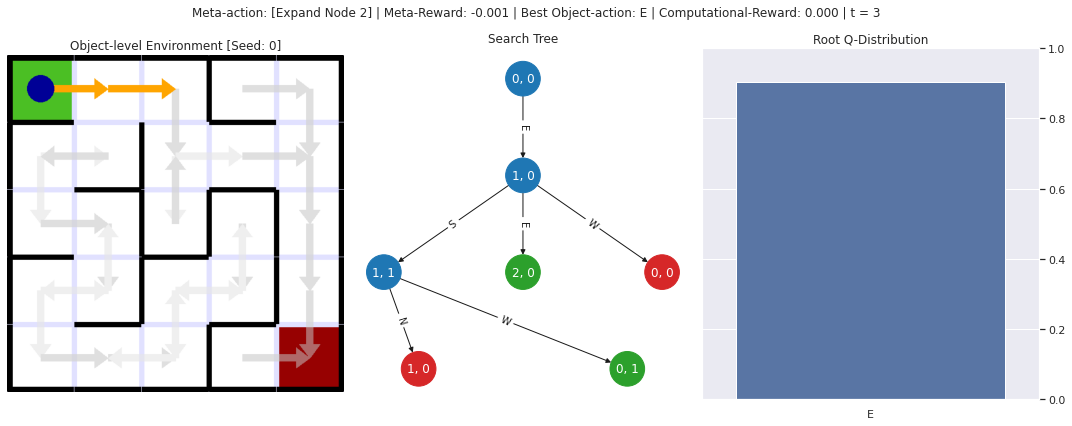

In [5]:
meta_env.render(plt_show=True);

In [7]:
import cProfile
from mlrl.experiments.ppo_maze import create_batched_maze_meta_envs, get_maze_name
from mlrl.experiments.ppo_runner import PPORunner
from mlrl.experiments.experiment_utils import create_parser

import numpy as np

from IPython.display import clear_output


def time_collect(samples=3, **overwrite_args):
    parser = create_parser()
    args = vars(parser.parse_args(args=[]))
    args.update(overwrite_args)

    env, eval_env, video_env = create_batched_maze_meta_envs(**args)
    ppo_runner = PPORunner(
        env, eval_env=eval_env, video_env=video_env,
        name=get_maze_name(args), **args
    )

    clear_output()

    with cProfile.Profile() as pr:
        collect_times = []
        train_times = []
        for _ in range(samples):
            logs = ppo_runner.collect()
            collect_times.append(logs['CollectTime'])
            logs.update(ppo_runner.train())
            train_times.append(logs['TrainTime'])

        print(f'Mean collect time: {np.mean(collect_times):.3f} +/- {np.std(collect_times):.3f}')
        print(f'Mean train time: {np.mean(train_times):.3f} +/- {np.std(train_times):.3f}')

        return pr, collect_times, train_times

In [8]:
profiles = {
    steps: time_collect(collect_steps=steps)
    for steps in [256, 512]
}

 0/16 [..............................] - ETA: 0s - RewrittenAverageReturn: 0.0525    Collect stats:
RewrittenAverageReturn: 0.090, NumberOfEpisodes: 38.000, EnvironmentSteps: 540.000, AverageReturn: 0.104, AverageEpisodeLength: 11.395, CollectTime: 17.818
Training info:
Loss: nan, KL Penalty Loss: 0.01730, Entropy: 0.00000, Value Estimation Loss: nan, PG Loss -0.08448, Train Time: 6.9 (s)

 1/16 [>.............................] - ETA: 11:29 - RewrittenAverageReturn: 0.0425   Collect stats:
RewrittenAverageReturn: 0.100, NumberOfEpisodes: 34.000, EnvironmentSteps: 542.000, AverageReturn: 0.112, AverageEpisodeLength: 12.265, CollectTime: 14.807
Training info:
Loss: nan, KL Penalty Loss: nan, Entropy: 0.00000, Value Estimation Loss: nan, PG Loss nan, Train Time: 0.6 (s)

Waiting for debugger attach
Debugger attached


In [ ]:
import pstats

for steps, (profile, collect_times, train_times) in profiles.items():
    p = pstats.Stats(profile)
    print(f'Collect steps: {steps}, Mean collect time:', np.mean(collect_times),
          'Mean train time:', np.mean(train_times))
    p.sort_stats('cumtime').print_stats(25)

In [11]:
import pstats

for steps, (profile, collect_times, train_times) in profiles.items():
    p = pstats.Stats(profile)
    print(f'Collect steps: {steps}, Mean collect time:', np.mean(collect_times),
          'Mean train time:', np.mean(train_times))
    p.sort_stats('cumtime').print_stats(25)

Collect steps: 256, Mean collect time: 4.084373474121094 Mean train time: 3.08332888285319
         9831957 function calls (9348093 primitive calls) in 21.883 seconds

   Ordered by: cumulative time
   List reduced from 3122 to 25 due to restriction <25>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   12.505    4.168 /tf/mlrl/experiments/ppo_runner.py:313(collect)
        3    0.000    0.000   12.253    4.084 /usr/local/lib/python3.8/dist-packages/tf_agents/train/actor.py:146(run)
        3    0.002    0.001   12.159    4.053 /usr/local/lib/python3.8/dist-packages/tf_agents/drivers/py_driver.py:89(run)
23296/3268    0.037    0.000   10.497    0.003 /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py:138(error_handler)
       27    0.000    0.000   10.363    0.384 /usr/local/lib/python3.8/dist-packages/tf_agents/environments/py_environment.py:198(step)
       27    0.000    0.000   10.363    0.384 /usr/l

In [12]:
from mlrl.utils.render_utils import create_random_policy_video, embed_mp4
meta_env = BatchedPyEnvironment([
    GymWrapper(create_meta_env(enable_rendering=True, min_computation_steps=5))
    for _ in range(2)
], multithreading=True)
embed_mp4(create_random_policy_video(meta_env, max_steps=60, rewrite_rewards=True))

In [ ]:
batch_size = 2
env = BatchedPyEnvironment([
    GymWrapper(create_meta_env()) for _ in range(batch_size)
], multithreading=False)

In [17]:
import pstats

for steps, (profile, times) in profiles.items():
    p = pstats.Stats(profile)
    print(f'Collect steps: {steps}, Mean time:', np.mean(times))
    p.sort_stats('cumtime').print_stats(25)

Collect steps: 256, Mean time: 4.407046715418498
         1585241 function calls (1512394 primitive calls) in 13.795 seconds

   Ordered by: cumulative time
   List reduced from 1564 to 25 due to restriction <25>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   13.658    4.553 /tf/mlrl/experiments/ppo_runner.py:312(collect)
        3    0.000    0.000   13.221    4.407 /usr/local/lib/python3.8/dist-packages/tf_agents/train/actor.py:146(run)
        3    0.002    0.001   13.135    4.378 /usr/local/lib/python3.8/dist-packages/tf_agents/drivers/py_driver.py:89(run)
       27    0.000    0.000   11.438    0.424 /usr/local/lib/python3.8/dist-packages/tf_agents/environments/py_environment.py:198(step)
       27    0.000    0.000   11.438    0.424 /usr/local/lib/python3.8/dist-packages/tf_agents/environments/batched_py_environment.py:150(_step)
       57    0.000    0.000   11.362    0.199 /usr/lib/python3.8/threading.py:540(wait)
       5

In [16]:
import pstats

for steps, (profile, times) in profiles.items():
    p = pstats.Stats(profile)
    print(f'Collect steps: {steps}, Mean time:', np.mean(times))
    p.sort_stats('cumtime').print_stats('mlrl', 15)

Collect steps: 256, Mean time: 4.407046715418498
         1585241 function calls (1512394 primitive calls) in 13.795 seconds

   Ordered by: cumulative time
   List reduced from 1564 to 64 due to restriction <'mlrl'>
   List reduced from 64 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   13.658    4.553 /tf/mlrl/experiments/ppo_runner.py:312(collect)
       27    0.008    0.000    0.969    0.036 /tf/mlrl/meta/retro_rewards_rewriter.py:251(__call__)
      197    0.002    0.000    0.700    0.004 /tf/mlrl/meta/retro_rewards_rewriter.py:220(rewrite_rewards)
      864    0.007    0.000    0.697    0.001 /tf/mlrl/meta/retro_rewards_rewriter.py:66(rewrite_reward)
      856    0.002    0.000    0.583    0.001 /tf/mlrl/meta/tree_policy.py:36(evaluate)
 4373/856    0.025    0.000    0.581    0.001 /tf/mlrl/meta/tree_policy.py:44(recursive_compute_value)
3517/1166    0.004    0.000    0.468    0.000 /tf/mlrl/meta

In [3]:
import pstats

for steps, profile in profiles.items():
    p = pstats.Stats(profile)
    print(f'Collect steps: {steps}')
    p.sort_stats('cumtime').print_stats('mlrl', 15)

Collect steps: 256
         1745710 function calls (1679610 primitive calls) in 13.204 seconds

   Ordered by: cumulative time
   List reduced from 1572 to 62 due to restriction <'mlrl'>
   List reduced from 62 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   13.068    4.356 /tf/mlrl/experiments/ppo_runner.py:312(collect)
       27    0.006    0.000    1.325    0.049 /tf/mlrl/meta/retro_rewards_rewriter.py:251(__call__)
      223    0.002    0.000    0.855    0.004 /tf/mlrl/meta/retro_rewards_rewriter.py:220(rewrite_rewards)
      864    0.007    0.000    0.852    0.001 /tf/mlrl/meta/retro_rewards_rewriter.py:66(rewrite_reward)
      856    0.002    0.000    0.746    0.001 /tf/mlrl/meta/tree_policy.py:36(evaluate)
 3901/856    0.023    0.000    0.744    0.001 /tf/mlrl/meta/tree_policy.py:44(recursive_compute_value)
9480/9452    0.017    0.000    0.620    0.000 /tf/mlrl/meta/q_estimation.py:47(estimate_o

In [25]:
import pstats

for steps, profile in profiles.items():
    p = pstats.Stats(profile)
    print(f'Collect steps: {steps}')
    p.sort_stats('cumtime').print_stats('mlrl', 15)

Collect steps: 64
         1031750 function calls (1016346 primitive calls) in 4.586 seconds

   Ordered by: cumulative time
   List reduced from 1565 to 62 due to restriction <'mlrl'>
   List reduced from 62 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    4.449    1.483 /tf/mlrl/experiments/ppo_runner.py:312(collect)
        3    0.000    0.000    0.449    0.150 /tf/mlrl/meta/retro_rewards_rewriter.py:179(flush_all)
       96    0.001    0.000    0.414    0.004 /tf/mlrl/meta/retro_rewards_rewriter.py:220(rewrite_rewards)
      192    0.002    0.000    0.413    0.002 /tf/mlrl/meta/retro_rewards_rewriter.py:66(rewrite_reward)
      384    0.001    0.000    0.405    0.001 /tf/mlrl/meta/tree_policy.py:37(evaluate)
  896/384    0.004    0.000    0.404    0.001 /tf/mlrl/meta/tree_policy.py:44(recursive_compute_value)
4408/2380    0.012    0.000    0.382    0.000 /tf/mlrl/meta/q_estimation.py:47(estimate_op

In [4]:
def time_multithreading(batch_size, samples=3, max_steps=256):

    times = []
    for i in range(samples):
        env = BatchedPyEnvironment([
            GymWrapper(create_meta_env()) for _ in range(batch_size)
        ], multithreading=True)

        from mlrl.experiments.ppo_runner import create_search_ppo_agent
        from mlrl.experiments.experiment_utils import create_parser

        parser = create_parser()
        config = vars(parser.parse_args(args=[]))

        agent = create_search_ppo_agent(env, config)

        from tf_agents.policies import py_tf_eager_policy

        policy = py_tf_eager_policy.PyTFEagerPolicy(
                    agent.collect_policy, use_tf_function=True, batch_time_steps=False)

        from tf_agents.drivers.py_driver import PyDriver
        from mlrl.meta.retro_rewards_rewriter import RetroactiveRewardsRewriter
        from tf_agents.replay_buffers import tf_uniform_replay_buffer

        replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=env.batch_size or 1,
            max_length=max_steps
        )
        
        rewards_rewriter = RetroactiveRewardsRewriter(env, replay_buffer.add_batch)
        py_driver = PyDriver(env, policy, observers=[rewards_rewriter], max_steps=max_steps)

        policy_state = policy.get_initial_state(env.batch_size or 1)

        import time
        start = time.time()
        py_driver.run(env.reset(), policy_state)
        end = time.time()
        times.append(end - start)
        print(f"Trial {i}: Batch size {batch_size} took {end - start:.3f} seconds")

    import numpy as np
    print(f"Batch size {batch_size} took a mean of {np.mean(times):.3f} +/- {np.std(times):.3f} seconds")

In [5]:
for batch_size in [1, 2, 4, 8, 16, 32, 64]:
    time_multithreading(batch_size, max_steps=256)

Trial 0: Batch size 1 took 15.743 seconds
Trial 1: Batch size 1 took 14.570 seconds
Trial 2: Batch size 1 took 15.287 seconds
Batch size 1 took a mean of 15.200 +/- 0.483 seconds
Trial 0: Batch size 2 took 10.146 seconds
Trial 1: Batch size 2 took 9.689 seconds
Trial 2: Batch size 2 took 9.613 seconds
Batch size 2 took a mean of 9.816 +/- 0.235 seconds
Trial 0: Batch size 4 took 7.566 seconds
Trial 1: Batch size 4 took 7.786 seconds
Trial 2: Batch size 4 took 7.180 seconds
Batch size 4 took a mean of 7.511 +/- 0.251 seconds
Trial 0: Batch size 8 took 6.443 seconds
Trial 1: Batch size 8 took 5.262 seconds
Trial 2: Batch size 8 took 6.035 seconds
Batch size 8 took a mean of 5.913 +/- 0.490 seconds
Trial 0: Batch size 16 took 4.993 seconds
Trial 1: Batch size 16 took 5.955 seconds
Trial 2: Batch size 16 took 7.548 seconds
Batch size 16 took a mean of 6.165 +/- 1.053 seconds
Trial 0: Batch size 32 took 5.727 seconds
Trial 1: Batch size 32 took 5.313 seconds
Trial 2: Batch size 32 took 4.77

In [10]:
for batch_size in [256, 512, 1024, 2048, 4096]:
    time_multithreading(batch_size, max_steps=4096)

Trial 0: Batch size 256 took 83.230 seconds
Trial 1: Batch size 256 took 62.666 seconds
Trial 2: Batch size 256 took 66.090 seconds
Batch size 256 took a mean of 70.662 +/- 8.996 seconds
Trial 0: Batch size 512 took 62.972 seconds
Trial 1: Batch size 512 took 70.591 seconds
Trial 2: Batch size 512 took 64.336 seconds
Batch size 512 took a mean of 65.967 +/- 3.317 seconds
Trial 0: Batch size 1024 took 55.093 seconds
Trial 1: Batch size 1024 took 44.561 seconds
Trial 2: Batch size 1024 took 50.891 seconds
Batch size 1024 took a mean of 50.182 +/- 4.329 seconds
Trial 0: Batch size 2048 took 38.078 seconds
Trial 1: Batch size 2048 took 43.438 seconds
Trial 2: Batch size 2048 took 40.522 seconds
Batch size 2048 took a mean of 40.680 +/- 2.191 seconds
Trial 0: Batch size 4096 took 26.116 seconds
Trial 1: Batch size 4096 took 30.301 seconds
Trial 2: Batch size 4096 took 29.790 seconds
Batch size 4096 took a mean of 28.736 +/- 1.864 seconds


In [18]:
meta_env = create_meta_env()
meta_env.step(1)
meta_env.step(2)

({'search_tree_tokens': array([[ 1.   ,  1.   ,  0.   , ...,  0.   ,  0.   ,  1.   ],
         [ 1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
         [ 1.   ,  0.   , -0.004, ...,  1.   ,  0.   ,  0.   ],
         ...,
         [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
         [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
         [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]]),
  'action_mask': array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)},
 0.011983670296344506,
 False,
 {'computational_reward': 0.012983670296344507, 'object_level_reward': 0})

In [19]:
meta_env.tree

{MazeState(0, 0)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.004]--> (MazeState(1, 1))
	|---[E, -0.004]--> (MazeState(2, 0))
	|---[W, -0.004]--> {MazeState(0, 0)}

In [24]:
from mlrl.maze.maze_utils import construct_maze_string

print(construct_maze_string(meta_env.object_env.maze_view))

|---|---|---|---|---|
| X         |       |
|---|   |   |---|   |
|       |           |
|   |---|   |---|   |
|       |   |   |   |
|---|   |---|   |   |
|       |       |   |
|   |---|   |---|   |
|           |       |
|---|---|---|---|---|



In [11]:
def main():
    env = BatchedPyEnvironment([
        GymWrapper(create_meta_env())
    ], multithreading=False)

    from mlrl.experiments.ppo_runner import create_search_ppo_agent
    from mlrl.experiments.experiment_utils import create_parser

    parser = create_parser()
    config = vars(parser.parse_args(args=[]))

    agent = create_search_ppo_agent(env, config)

    from tf_agents.policies import py_tf_eager_policy

    policy = py_tf_eager_policy.PyTFEagerPolicy(
                agent.collect_policy, use_tf_function=True, batch_time_steps=False)

    from tf_agents.drivers.py_driver import PyDriver
    from mlrl.meta.retro_rewards_rewriter import RetroactiveRewardsRewriter

    data = []
    rewards_rewriter = RetroactiveRewardsRewriter(env, agent.collect_data_spec, data.append)
    py_driver = PyDriver(env, policy, observers=[rewards_rewriter], max_steps=100)

    policy_state = policy.get_initial_state(env.batch_size or 1)

    py_driver.run(env.reset(), policy_state)


import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()
main()
profiler.disable()

In [12]:
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

         3329060 function calls (3249220 primitive calls) in 8.379 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    8.380    4.190 /usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3361(run_code)
        2    0.000    0.000    8.380    4.190 {built-in method builtins.exec}
        1    0.002    0.002    8.380    8.380 /tmp/ipykernel_15461/3639192703.py:34(<cell line: 34>)
        1    0.001    0.001    8.355    8.355 /tmp/ipykernel_15461/3639192703.py:1(main)
        1    0.014    0.014    7.760    7.760 /usr/local/lib/python3.8/dist-packages/tf_agents/drivers/py_driver.py:89(run)
7996/2406    0.015    0.000    7.018    0.003 /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py:138(error_handler)
      146    0.003    0.000    6.671    0.046 /usr/local/lib/python3.8/dist-packages/tf_agents/policies/py_policy.py:140(action)
      146    0.002  

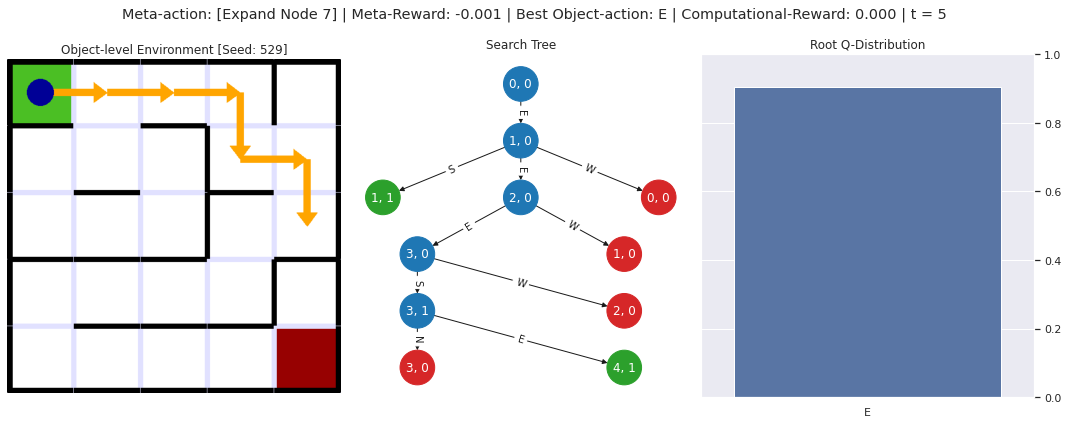

Estimating value of new policy:
 {MazeState(0, 0)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.004]--> (MazeState(1, 1))
	|---[E, -0.004]--> {MazeState(2, 0)}
		|---[E, -0.004]--> {MazeState(3, 0)}
			|---[S, -0.004]--> {MazeState(3, 1)}
				|---[N, -0.004]--> {MazeState(3, 0)}
				|---[E, -0.004]--> {MazeState(4, 1)}
					|---[N, -0.004]--> (MazeState(4, 0))
					|---[S, -0.004]--> (MazeState(4, 2))
					|---[W, -0.004]--> {MazeState(3, 1)}
			|---[W, -0.004]--> {MazeState(2, 0)}
		|---[W, -0.004]--> {MazeState(1, 0)}
	|---[W, -0.004]--> {MazeState(0, 0)}
P(E | MazeState(0, 0)) = 1.0
P(S | MazeState(1, 0)) = 1.0
P(E | MazeState(1, 1)) = 1.0
Leaf evaluation: Q-hat(MazeState(1, 1), E) = 0.93139
Value(MazeState(1, 1)) = 0.93139
Recursive Q-hat(MazeState(1, 0), S) = 0.918 
Value(MazeState(1, 0)) = 0.91807
Recursive Q-hat(MazeState(0, 0), E) = 0.905 
Value(MazeState(0, 0)) = 0.90489

Estimating value of prior policy:
 {MazeState(0, 0)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.

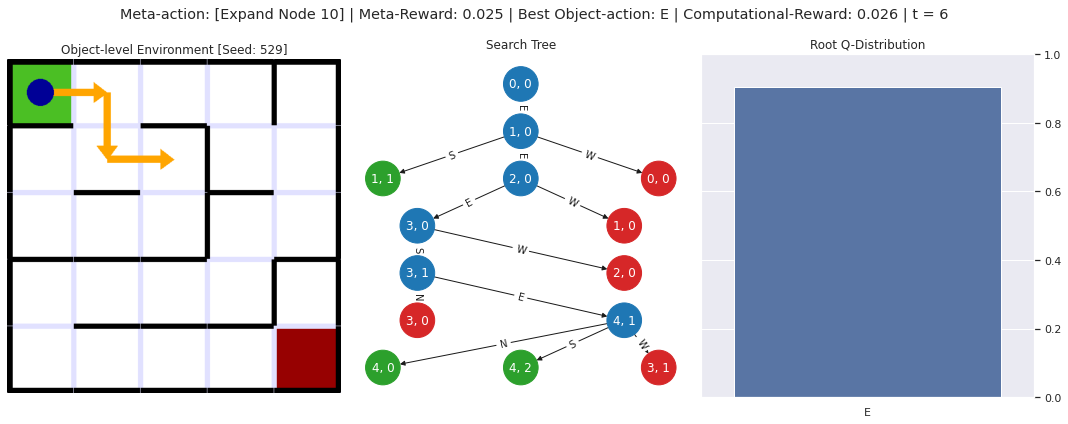

In [7]:
meta_env = create_meta_env(seed=529)
for a in [1, 2, 4, 6, 8]:
    meta_env.step(a)
meta_env.render(plt_show=True)
meta_env.step(11, verbose=True)
meta_env.render(plt_show=True);

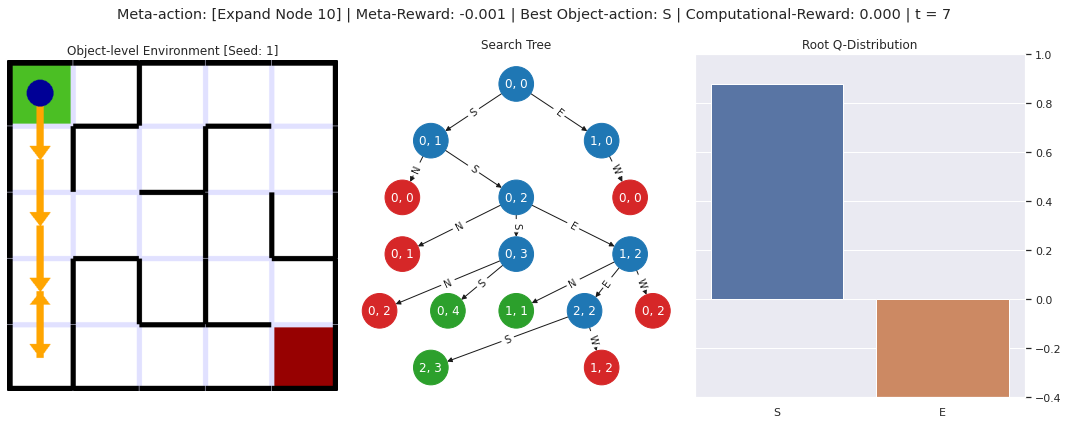

Estimating value of new policy:
 {MazeState(0, 0)}
|---[S, -0.004]--> {MazeState(0, 1)}
	|---[N, -0.004]--> {MazeState(0, 0)}
	|---[S, -0.004]--> {MazeState(0, 2)}
		|---[N, -0.004]--> {MazeState(0, 1)}
		|---[S, -0.004]--> {MazeState(0, 3)}
			|---[N, -0.004]--> {MazeState(0, 2)}
			|---[S, -0.004]--> {MazeState(0, 4)}
				|---[N, -0.004]--> {MazeState(0, 3)}
		|---[E, -0.004]--> {MazeState(1, 2)}
			|---[N, -0.004]--> (MazeState(1, 1))
			|---[E, -0.004]--> {MazeState(2, 2)}
				|---[S, -0.004]--> (MazeState(2, 3))
				|---[W, -0.004]--> {MazeState(1, 2)}
			|---[W, -0.004]--> {MazeState(0, 2)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[W, -0.004]--> {MazeState(0, 0)}
P(S | MazeState(0, 0)) = 1.0
P(S | MazeState(0, 1)) = 1.0
P(E | MazeState(0, 2)) = 1.0
P(N | MazeState(1, 2)) = 1.0
P(S | MazeState(1, 1)) = 1.0
Leaf evaluation: Q-hat(MazeState(1, 1), S) = 0.93139
Value(MazeState(1, 1)) = 0.93139
Recursive Q-hat(MazeState(1, 2), N) = 0.918 
Value(MazeState(1, 2)) = 0.91807
Recursive Q-

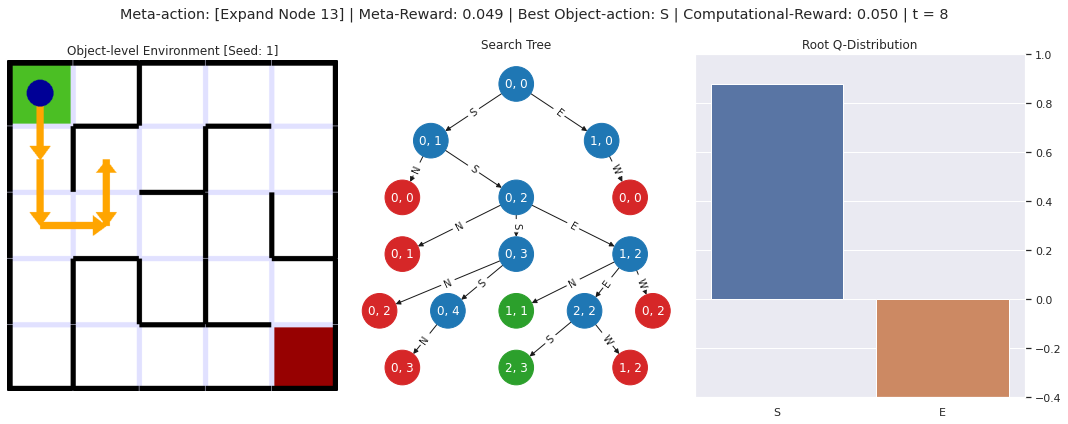

In [8]:
meta_env = create_meta_env(seed=1)
for a in [1, 2, 5, 3, 8, 7, 11]:
    meta_env.step(a)
meta_env.render(plt_show=True)
meta_env.step(14, verbose=True)
meta_env.render(plt_show=True);

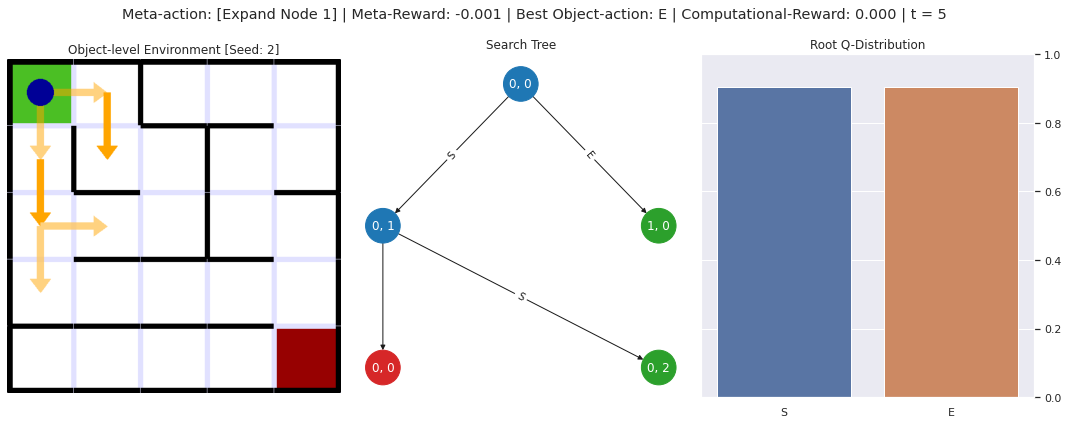

In [11]:
meta_env = create_meta_env(enable_rendering=True)
meta_env.reset()
meta_env.reset()

for i in range(3):
    meta_env.step(0)
meta_env.step(1)
# meta_env.render(plt_show=True);
meta_env.step(2)
# meta_env.step(4)
# meta_env.step(5)
# meta_env.step(0)
meta_env.render(plt_show=True);
# meta_env.step(3)
# # meta_env.step(9, verbose=True)
# meta_env.render(plt_show=True);
# meta_env.step(7, verbose=True)
# meta_env.render(plt_show=True);


In [16]:
node = meta_env.tree.node_list[1]
node.children, node

({-1: [{MazeState(0, 0)}], 1: [(MazeState(0, 2))]},
 {MazeState(0, 1)}
 |---[N, -0.004]--> {MazeState(0, 0)}
 |---[S, -0.004]--> (MazeState(0, 2)))

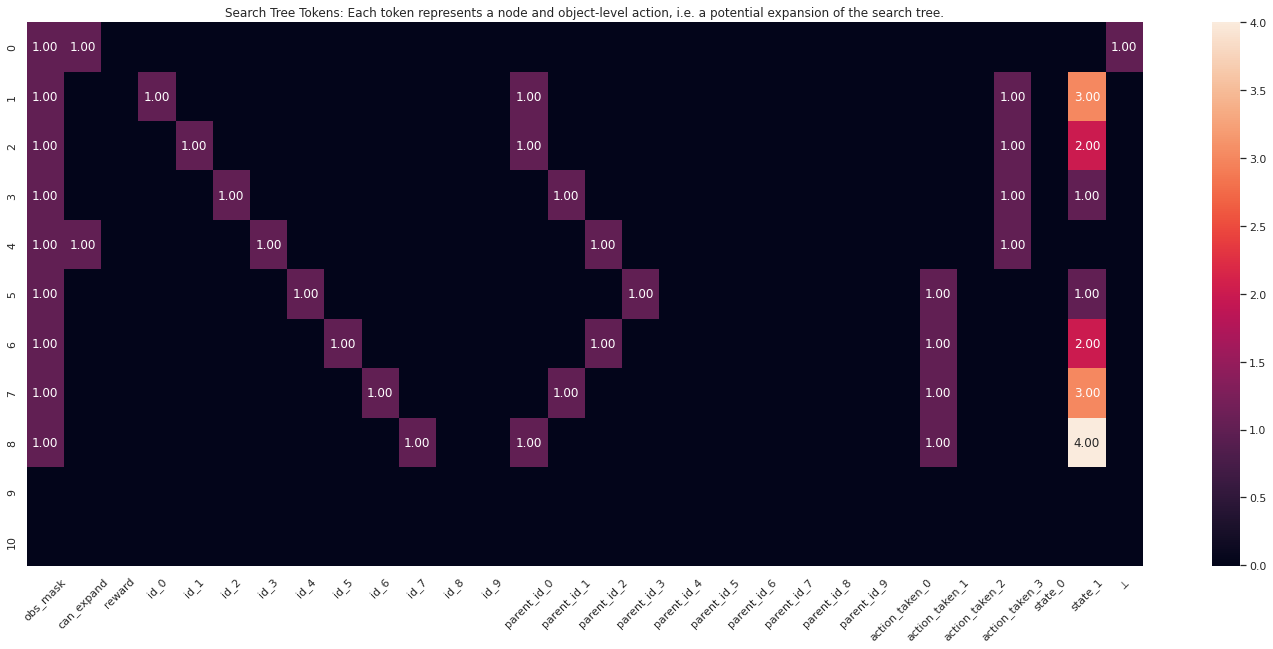

In [8]:
meta_env.plot_search_tokens(annot_fmt='.2f')

In [3]:
import numpy as np
env.reset()

for _ in range(8):
    actions = env.current_time_step().observation['valid_action_mask'].numpy()[0]
    actions[0] = 0
    action = np.random.choice(np.arange(len(actions)), p=actions/actions.sum())
    env.step(action)

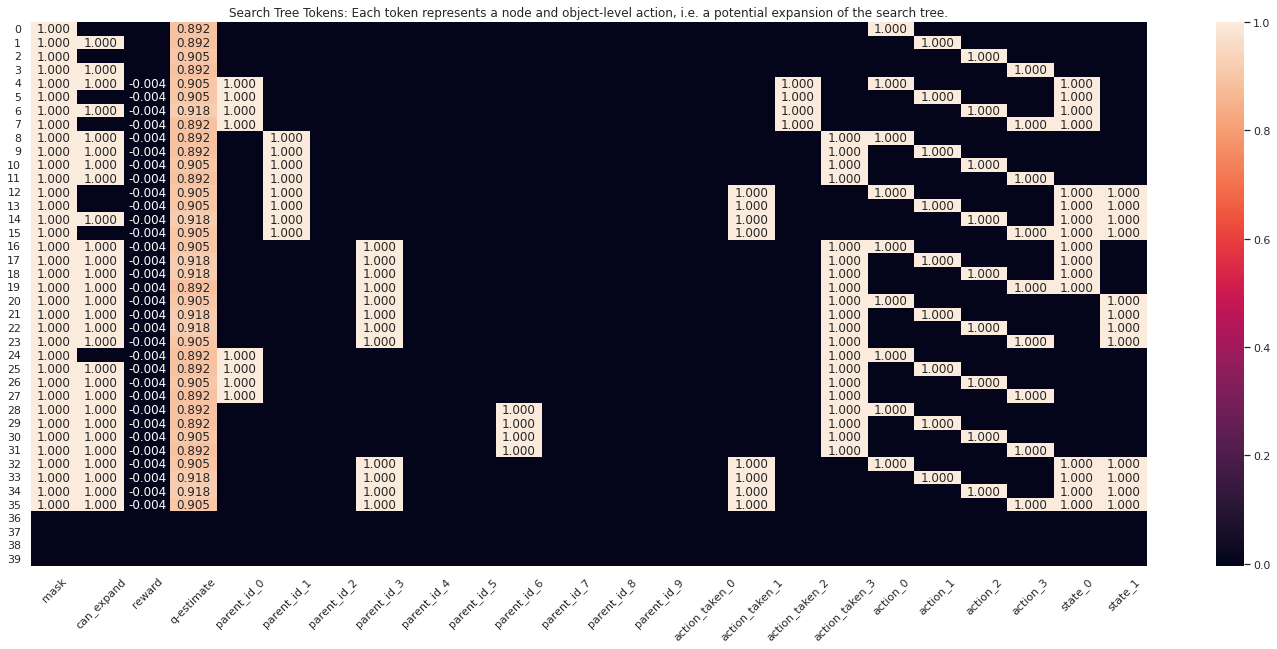

In [5]:
meta_env.plot_search_tokens()

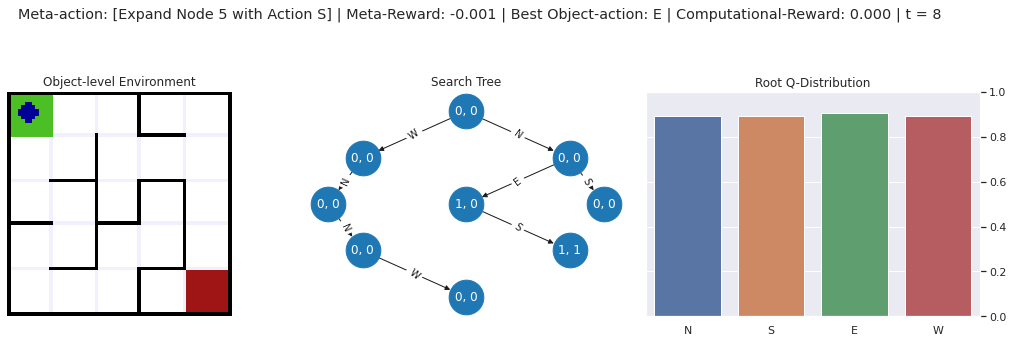

In [15]:
meta_env.render(plt_show=True);

In [ ]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper


object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64),
    generate_new_maze_on_reset=False
)

q_hat = ManhattanQHat(object_env)
init_state = RestrictedActionsMazeState.extract_state(object_env)
initial_tree = SearchTree(object_env, init_state, q_hat)
meta_env = MetaEnv(object_env, initial_tree, max_tree_size=10, 
                   object_action_to_string=lambda a: object_env.ACTION[a])

env = TFPyEnvironment(GymWrapper(meta_env))

In [10]:
from tf_agents.policies import TFPolicy
from tf_agents.environments.tf_environment import TFEnvironment
import numpy as np


def compute_return_stats(environment: TFEnvironment,
                         policy: TFPolicy,
                         num_episodes: int = 3,
                         max_steps: int = 100) -> float:
    """
    Computes mean and standard deviation for returns of a policy on a given environment.
    """

    returns = []
    rewards = []
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
        n_steps = 0
        while not time_step.is_last() and n_steps < max_steps:
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            rewards.append(time_step.reward.numpy()[0])
            n_steps += 1

        returns.append(episode_return)

    returns = np.array(returns)

    return returns.mean(), returns.std(), rewards

In [11]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from mlrl.meta.meta_env import mask_invalid_action_constraint_splitter

random_policy = RandomTFPolicy(
    env.time_step_spec(),
    env.action_spec(),
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter
)

In [43]:
mean_return, return_std, rewards = compute_return_stats(env, random_policy, num_episodes=20)

In [45]:
rewards = [r.numpy()[0] for r in rewards]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


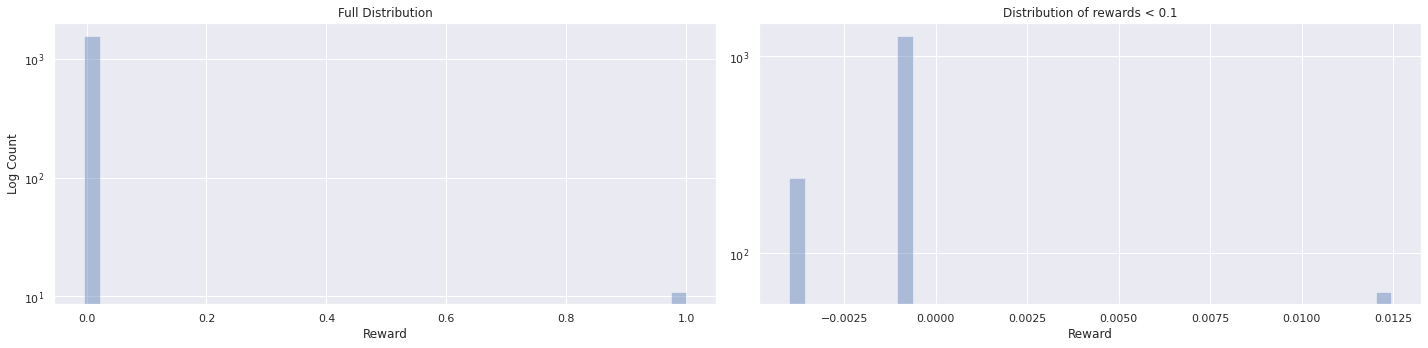

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

t = 0.1

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(rewards, ax=axs[0], kde=False)
sns.distplot([r for r in rewards if r < t], ax=axs[1], kde=False)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Reward')

axs[0].set_ylabel('Log Count')
axs[1].set_ylabel('')
axs[0].set_title('Full Distribution')
axs[1].set_title(f'Distribution of rewards < {t}')
plt.tight_layout()
plt.show()